# Coursework 1: Convolutional Neural Networks 
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed :)

### Setting up working environment 

For this coursework you will need to train a large network, therefore we recommend you work with Google Colaboratory or Lab cluster, where you can access GPUs.

Please refer to the Intro lecture for getting set up on the various GPU options.

**To run the public tests within colab** you will need to copy the "tests" folder to the /content/ directory (this is the default working directory - you can also change directories with %cd). You may also need to place a copy of the CW ipynb in the /content/ directory. A better option is to mount colab on gdrive and keep the files there (so you only need to do the set up once).

#### Setup
You will need to install pytorch and other libraries by running the following cell:

<font color="orange">**The deadline for submission is Tuesday, 6 Feb by 6 pm** </font>

In [6]:
!pip install -q otter-grader pandoc torch torchvision scikit-learn seaborn numpy

In [4]:
# Initialization Cell
try:
    WORKING_ENV = 'COLAB' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
    USERNAME = 'your_username' # If working on Lab Machines - Your college username
    assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

    if WORKING_ENV == 'COLAB':
        from google.colab import drive
        %load_ext google.colab.data_table
        d1_cw1_repo_path = 'Lectureship/CW/dl_cw1/' # path in your gdrive to the repo
        content_path = f'/content/drive/MyDrive/{d1_cw1_repo_path}' # path to gitrepo in gdrive after mounting
        drive.mount('/content/drive/') # Outputs will be saved in your google drive

    elif WORKING_ENV == 'LABS':
        content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw1/' # You may want to change this
        # Your python env and training data should be on bitbucket
        if 'vol' not in content_path:
            import warnings
            warnings.warn(
                'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
            )

    elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
        # Paperspace does not properly render animated progress bars
        # Strongly recommend using the JupyterLab UI instead of theirs
        !pip install ipywidgets
        content_path = '/notebooks'

    elif WORKING_ENV == 'SAGEMAKER':
        content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/'
    else:
        raise NotImplementedError()

    import otter
    import os
    if not os.path.exists(f'{content_path}tests'):
        raise ValueError('Cannot find the public tests folder')
    grader = otter.Notebook(
        f'{content_path}dl_cw_1.ipynb',
        tests_dir=f'{content_path}tests')
    import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
    import numpy as np
    rng_seed = 90
except:
    # This is a fallback initialization for running on LabTS. Please leave this in place before submission.
    import otter
    grader = otter.Notebook("dl_cw_1.ipynb")
    import matplotlib.pyplot as plt
    import numpy as np
    rng_seed = 90


## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations. 
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (The one exception is that the class inherits from nn.Module)

_hint: check out F.unfold and F.fold, they may be helpful_

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - w: Filter weights of shape (F, C, H', W',)
        - b: Biases of shape (F,)
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        
        if isinstance(padding, int):
            padding = (padding, padding)
            
        if isinstance(stride, int):
            stride = (stride, stride)
        
        # Do not initialize weights or biases with torch.empty() but rather use torch.zeros()
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        self.w = torch.zeros(out_channels, in_channels, kernel_size[0], kernel_size[1])
        # Bias should have shape [out_channels] 
        self.b = torch.zeros(out_channels) if bias else None
        self.F = out_channels
        self.C = in_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        (_, C, H, W) = x.shape
        assert C == self.C
        
        x_unfold = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        w_unfold = self.w.view(self.w.size(0), -1)
        x_conv = x_unfold\
            .transpose(1, 2)\
            .matmul(w_unfold.t())\
            .add(self.b)\
            .transpose(1, 2)
        
        # Calculate output size then aggregate values back
        w_out = (W + 2 * self.padding[1] - self.kernel_size[1]) / self.stride[1] + 1
        h_out = (H + 2 * self.padding[0] - self.kernel_size[0]) / self.stride[0] + 1
        w_out = int(w_out)
        h_out = int(h_out)
        
        out = F.fold(x_conv, output_size=(h_out, w_out), kernel_size=(1, 1))
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [9]:
# Testing

from numpy.random import randint

padding = tuple(randint(1, 5, (2,)))
stride = tuple(randint(1, 5, (2,)))

in_channels = randint(1, 10)
out_channels = randint(1, 10)
kernel_size = tuple(randint(1, 5, (2,)))

conv = Conv2d(in_channels, out_channels, kernel_size, padding=padding, stride=stride, bias=True)
# Set weight and bias to something other than 0
conv.w = torch.randn(*conv.w.shape)
conv.b = torch.randn(*conv.b.shape)

x = torch.randn(
    randint(1, 10),
    in_channels,
    randint(10, 20),
    randint(10, 20),
)

# Expect 0 everywhere
print(
    torch.allclose(
        F.conv2d(x, conv.w, padding=padding, stride=stride, bias=conv.b),
        conv(x),
    )
)

True


In [10]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer.

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window to take a max over
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        self.kernel_size = kernel_size
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """

        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        (_, C, H, W) = x.shape
        
        # COMMENTED CODE WORKS ONLY FOR IN_CHANNELS = 1
        
        # x_unfold = F.unfold(x, kernel_size=self.kernel_size, stride=self.kernel_size)
        # x_maxpool = torch.max(x_unfold, dim=1)[0]
        
        # # Calculate output size then aggregate values back
        # w_out = (W - self.kernel_size[1]) / self.kernel_size[1] + 1
        # h_out = (H - self.kernel_size[0]) / self.kernel_size[0] + 1
        # w_out = int(w_out)
        # h_out = int(h_out)
        
        # out = F.fold(x_maxpool, output_size=(h_out, w_out), kernel_size=(1, 1))

        x_window = x\
            .unfold(2, self.kernel_size[0], self.kernel_size[0])\
            .unfold(3, self.kernel_size[1], self.kernel_size[1])\
            .contiguous()

        x_window = x_window.view(*x_window.size()[:-2], -1)
        out = x_window.max(4)[0]
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        return out

In [12]:
# Testing

from numpy.random import randint

in_channels = randint(1, 10)
kernel_size = tuple(randint(1, 5, (2,)))

maxpool = MaxPool2d(kernel_size)

x = torch.randn(
    randint(1, 10),
    in_channels,
    randint(10, 20),
    randint(10, 20),
)

# Expect 0 everywhere
print(
    torch.allclose(
        F.max_pool2d(x, kernel_size=kernel_size),
        maxpool(x),
    )
)

True


In [13]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

In [14]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
        # Also no initialisation methods for this reason

        self.w = torch.zeros(in_channels, out_channels)
        self.b = torch.zeros(out_channels) if bias else None

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        out = x.matmul(self.w) + self.b
        
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [15]:
# Testing

linear = Linear(in_channels=3, out_channels=5)
x = torch.randn(10, 6, 7, 8, 3)

# Expect (10, 6, 7, 8, 5)
print(linear(x).shape)

torch.Size([10, 6, 7, 8, 5])


In [16]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [17]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-05, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        """
        An implementation of a Batch Normalization over a mini-batch of 2D inputs.

        The mean and standard-deviation are calculated per-dimension over the
        mini-batches and gamma and beta are learnable parameter vectors of
        size num_features.

        Parameters:
        - num_features: C from an expected input of size (N, C, H, W).
        - eps: a value added to the denominator for numerical stability. Default: 1e-5
        - momentum: the value used for the running_mean and running_var
        computation. Default: 0.1 . (i.e. 1-momentum for running mean)
        - gamma: the learnable weights of shape (num_features).
        - beta: the learnable bias of the module of shape (num_features).
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
  
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # self.register_parameter is not used as it was mentioned on piazza
        # that this will be overridden
  
        self.gamma = torch.ones((1, num_features, 1, 1))
        self.beta = torch.zeros((1, num_features, 1, 1))
        
        # Keep track of running mean and variance
        self.moving_mean = torch.zeros((1, num_features, 1, 1))
        self.moving_var = torch.ones((1, num_features, 1, 1))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            

    def forward(self, x):
        """
        During training this layer keeps running estimates of its computed mean and
        variance, which are then used for normalization during evaluation.
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data of shape (N, C, H, W) (same shape as input)
        """
        #       Implement the forward pass                                     #
        #       (be aware of the difference for training and testing)          #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
        if self.training:
            mean = x.mean(dim=(0, 2, 3), keepdim=True)
            var = ((x - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
            
            x = (x - mean) / torch.sqrt(var + self.eps)
            
            # Update running mean and variance
            self.moving_mean = mean * self.momentum + (1 - self.momentum) * self.moving_mean
            self.moving_var = var * self.momentum + (1 - self.momentum) * self.moving_var
        else:
            # Moving average
            x = (x - self.moving_mean) / torch.sqrt(self.moving_var + self.eps)
        
        x *= self.gamma + self.beta
  
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return x

In [18]:
# Testing

from numpy.random import randint

in_channels = randint(1, 10)

x = torch.randn(
    randint(1, 10),
    in_channels,
    randint(10, 20),
    randint(10, 20),
)

m = BatchNorm2d(num_features=in_channels)
m_lib = nn.BatchNorm2d(num_features=in_channels)

# Expect 0 everywhere
print(
    torch.allclose(
        m(x),
        m_lib(x),
    )
)

True


In [19]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

## Part 2 (40 points)

In this part, you will design, train and optimise a custom deep learning model for classifying a specially selected subset of Imagenet. Termed NaturalImageNet, it is made up of a hand selected subset of the famous ImageNet dataset. The dataset contains 20 classes, all animals from the natural world. We hope that this dataset will be fun to work with but also a challenge.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (28 points)
    * 8 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 20 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (12 points)

**Downloading NaturalImageNet**

In [20]:
ON_COLAB = False

!wget https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
!wget https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
if ON_COLAB:
    !unzip /content/NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip /content/NaturalImageNetTrain.zip?download=1 > /dev/null
else: 
    !unzip NaturalImageNetTest.zip?download=1 > /dev/null
    !unzip NaturalImageNetTrain.zip?download=1 > /dev/null

zsh:1: no matches found: https://zenodo.org/record/5846979/files/NaturalImageNetTest.zip?download=1
zsh:1: no matches found: https://zenodo.org/record/5846979/files/NaturalImageNetTrain.zip?download=1
zsh:1: no matches found: NaturalImageNetTest.zip?download=1
zsh:1: no matches found: NaturalImageNetTrain.zip?download=1


In [1]:
#torch
import torch

#other
import matplotlib.pyplot as plt
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

In [22]:
# Run once your have trained your final model

from test import network_performance

network_performance(model_load_path="model_parole.pt")

KeyboardInterrupt: 

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Hyperparameter Search:
Given such a network with a large number of trainable parameters, and a training set of a large number of data, what do you think is the best strategy for hyperparameter searching? (3 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Engineering Decisions 

Detail which engineering decisions you made to boost the performance of the baseline results. Why do you think that they helped? (7 points)

**Answer:**

I started out by modularising the code into multiple `.py` files for ease of
maintainability, as well as some small fixes like specifying no shuffling in the
test `DataLoader` and parameterising functions like `split_dataset`.

The baseline model yields a test accuracy of 36.45% but a train accuracy of
99.99% (17984/17986). This can be verified by checking out to commit `61c5782c`
and using the script below. (Note: rolling back reverts the `ResNet` class to
the corresponding architecture to load `model_baseline.pt`. If you run the
script without reverting, it will fail! This will also revert this notebook
file, so please create a copy of the submitted version.) This suggests the model
is heavily overfitting.

```sh
# Revert to commit 61c5782c then run
python -m test --model_load_path model_baseline.pt
```

To combat overfitting, I considered the following changes:
- **input augmentation** - A common technique is to artificially increase the
  training set by applying random transformations to the original images,
  yielding new images for training. However, training time scales linearly with
  size of training set. Instead, I modify the input pipeline to apply random
  transformations **during training**. That is, during each epoch, the input
  image is transformed before being input into the model. This increases
  diversity while keeping training time constant (assuming transformations are
  applied in constant time), resulting in a more robust model. This technique
  has been applied in previous works, yielding improved results on datasets such
  as CIFAR-10 and Tiny ImageNet (see references below).
```tex
@inproceedings{he2016deep,
  title={Deep residual learning for image recognition},
  author={He, Kaiming and Zhang, Xiangyu and Ren, Shaoqing and Sun, Jian},
  booktitle={Proceedings of the IEEE conference on computer vision and pattern recognition},
  pages={770--778},
  year={2016}
}

@article{krizhevsky2012imagenet,
  title={Imagenet classification with deep convolutional neural networks},
  author={Krizhevsky, Alex and Sutskever, Ilya and Hinton, Geoffrey E},
  journal={Advances in neural information processing systems},
  volume={25},
  year={2012}
}

@article{rebuffi2021data,
  title={Data augmentation can improve robustness},
  author={Rebuffi, Sylvestre-Alvise and Gowal, Sven and Calian, Dan Andrei and Stimberg, Florian and Wiles, Olivia and Mann, Timothy A},
  journal={Advances in Neural Information Processing Systems},
  volume={34},
  pages={29935--29948},
  year={2021}
}

@article{sun2016resnet,
  title={Resnet on tiny imagenet},
  author={Sun, Lei},
  journal={Submitted on},
  volume={14},
  year={2016}
}
```
- **dropout layer** - I chose **not** to include this, since the skeleton code
  has implemented batch normalisation which has a similar effect of regularising
  as dropout.

I also modified `ResNet` to match Table 1 of `\cite{he2016deep}`, namely, adding
a max pooling layer after the 1st convolutional layer, and using an average
pooling layer at the end. The max pooling layer reduces parameter size which
helps to prevent overfitting.

With these changes, we get a train accuracy of 48.01% and a test accuracy of
43.85%. To verify this, check out to commit `1492b876` and run the script below.
This is a significant improvement over the baseline model, and the train
accuracy suggests our model is no longer overfitting.

```sh
# Revert to commit 1492b876 then run
python -m test --model_load_path model_dolly.pt
# To train from scratch. model_dolly should be same as model_dolly_clone.
python -m train --model_save_path model_dolly_clone.pt
```

The model is still learn after 10 epochs, so I replaced the optimiser and
scheduler with AdamW and increase the learning rate to `1e-4`. This had worked
well in previous image classification works, including my BEng project.
- https://github.com/j-freddy/simclr-medical-imaging

With these changes, we get a test accuracy of 51.45%, over 7% improvement. To
verify this, check out to commit `53301f95` and run the script below.

```sh
# Revert to commit 53301f95 then run
python -m test --model_load_path model_parole.pt
# To train from scratch. model_parole should be same as model_parole_clone.
python -m train --model_save_path model_parole_clone.pt
```

The training loss and validation accuracy curves for `model_parole.pt` are
presented below. This can be verified by running `tensorboard --logdir=runs` and
selecting `model-parole`.

### Traning loss

![parole_train_loss](parole-loss.png)

### Validation accuracy

![parole_val_acc](parole-acc.png)

The graphs suggest that the model is still learning after 10 epochs, so we
hypothesise that this setup is capable of achieving over 51% test accuracy.

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.3: Out of distribution evaluation

Lets see how your trained model performs when evaluated on cartoons of the 20 animal classes. Do not try and modify your model to perform well on this task, this is just a reflective exercise. How did your model perform at the task? Why do you think this was the case? Detail one method which you expect would improve model performance. (2 points)

In [8]:
ON_COLAB = False

!wget https://zenodo.org/records/10424022/files/cartoons.zip?download=1

if ON_COLAB:
    !unzip /content/cartoons.zip?download=1 > /dev/null

else:
    !unzip cartoons.zip?download=1 > /dev/null

zsh:1: no matches found: https://zenodo.org/records/10424022/files/cartoons.zip?download=1


zsh:1: no matches found: cartoons.zip?download=1


In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

In [9]:
mean = torch.Tensor([0.485, 0.456, 0.406]) # assuming same dist as imagenet
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]

    )
cartoon_path = ('/content/' if ON_COLAB else '') + 'cartoons'


cartoon_dataset = datasets.ImageFolder(cartoon_path, transform=transform)

print(len(cartoon_dataset))

batch_size = 128

cartoon_loader = DataLoader(cartoon_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

400


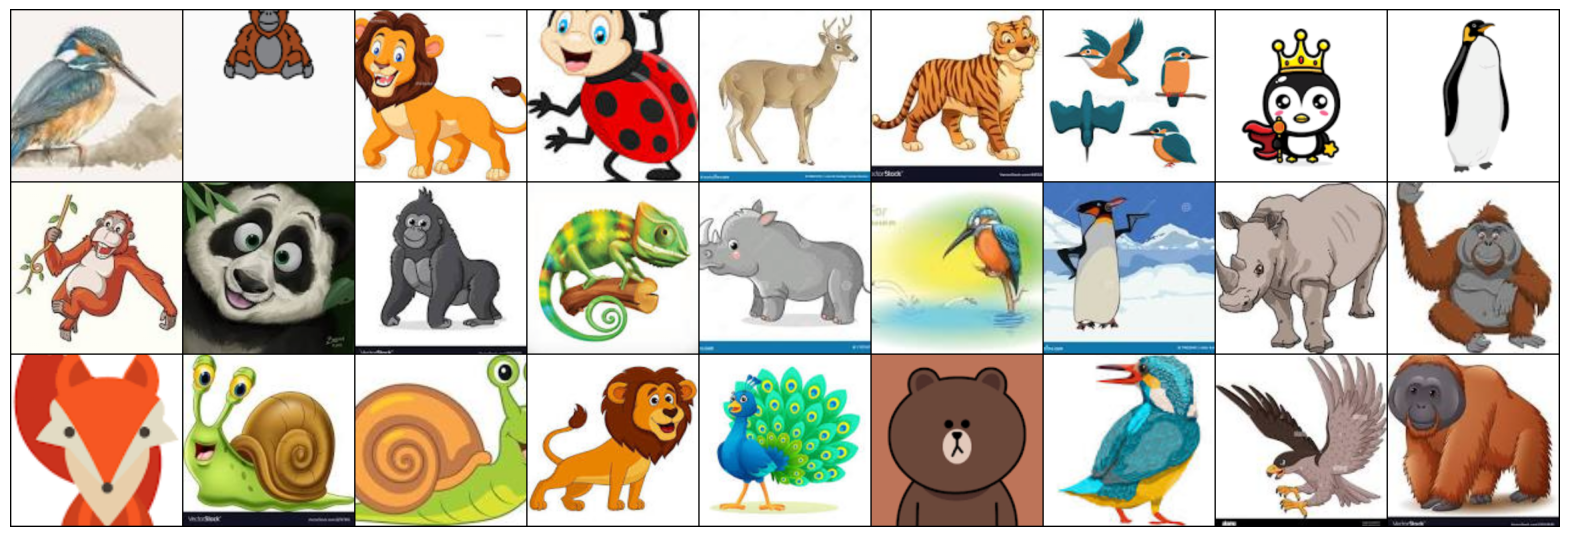

In [10]:
from utils import denorm, show

sample_inputs, _ = next(iter(cartoon_loader))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

In [12]:
from test import test_out_of_distribution

test_out_of_distribution(model_load_path="model_parole.pt", loader=cartoon_loader)

TypeError: test_out_of_distribution() got an unexpected keyword argument 'cartoon_loader'

**Answer:**

ANSWER HERE

<!-- END QUESTION -->

## Part 3 (10 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and **answer the following questions*(: 

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (4 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (4 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.3: Alternative Evaluations

What are the other possible ways to analyse the performance of your network? (2 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture). 

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [ ]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))
        

    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2
        
        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

<!-- BEGIN QUESTION -->



In [ ]:
# Visualize the figure here, so it is exported nicely
plot_model_features()  

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()